In [1]:
%matplotlib inline

In [2]:
import numpy as np
import xarray as xr
import pandas as pd

import scipy.spatial
import scipy.linalg

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

import plotly.plotly as py
import plotly.graph_objs as go

from ipywidgets import *

In [3]:
import rpy2.robjects as robjs
from rpy2.robjects.packages import importr
import statsmodels.api as sm
from IPython.display import display
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [4]:
# Import R packages in Python
r = robjs.r
nlme = importr('nlme')
stats = importr('stats')
#gstat = importr('gstat')
#sp = importr('sp')

In [5]:
#import rpy2.interactive as ri

In [6]:
#utils = importr('utils')

In [7]:
#utils.install_packages('gstat')

In [8]:
# Load the data
# wget ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G10010/G10010_SIBT1850_v1.1.zip
nc = xr.open_dataset('data/G10010_SIBT1850_v1.1.nc')

# View data
print(nc)

<xarray.Dataset>
Dimensions:        (latitude: 240, longitude: 1440, time: 1968)
Coordinates:
  * latitude       (latitude) float32 89.875 89.625 89.375 89.125 88.875 ...
  * longitude      (longitude) float32 0.125 0.375 0.625 0.875 1.125 1.375 ...
  * time           (time) datetime64[ns] 1850-01-15 1850-02-15 1850-03-15 ...
Data variables:
    seaice_conc    (time, latitude, longitude) float32 99.2614 99.2614 ...
    seaice_source  (time, latitude, longitude) float32 21.0 21.0 21.0 21.0 ...
Attributes:
    CDI:                       Climate Data Interface version 1.6.2 (http://c...
    Conventions:               CF-1.4
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 1.6.2 (http://c...
    NCO:                       4.4.2
    version:                   1.0
    release_date:              December_30,_2015
    history:                   Updated G10010_SIBT1850.nc; Enforced consisten...
    filename:                  G10010_SIBT1850_v1.01i


In [9]:
# View seaice concentration
nc.seaice_conc

<xarray.DataArray 'seaice_conc' (time: 1968, latitude: 240, longitude: 1440)>
[680140800 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 89.875 89.625 89.375 89.125 88.875 88.625 ...
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 ...
  * time       (time) datetime64[ns] 1850-01-15 1850-02-15 1850-03-15 ...
Attributes:
    short_name:     concentration
    long_name:      Sea_Ice_Concentration
    standard_name:  Sea_Ice_Concentration
    units:          Percent

In [10]:
# See what dates we have
nc.time

<xarray.DataArray 'time' (time: 1968)>
array(['1850-01-15T00:00:00.000000000', '1850-02-15T00:00:00.000000000',
       '1850-03-15T00:00:00.000000000', ..., '2013-10-15T00:00:00.000000000',
       '2013-11-15T00:00:00.000000000', '2013-12-15T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1850-01-15 1850-02-15 1850-03-15 ...
Attributes:
    standard_name:  time

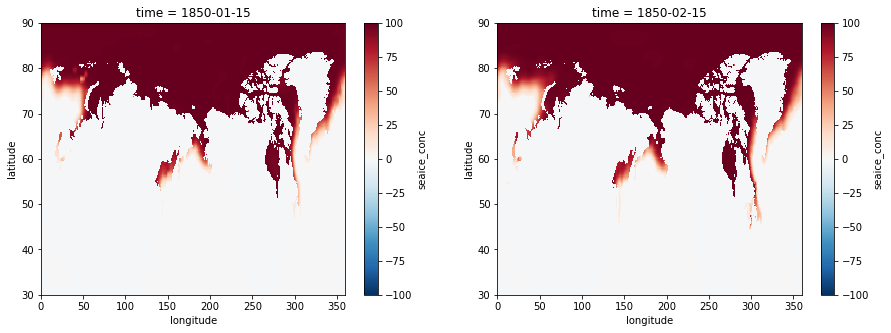

In [11]:
# Take a look at seaice_conc by plotting
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
nc.seaice_conc[0].plot(ax=ax1)
nc.seaice_conc[1].plot(ax=ax2)

In [12]:
# Average out years
yr_avg = nc.seaice_conc.groupby('time.year').mean()

In [13]:
yr_avg

<xarray.DataArray 'seaice_conc' (year: 164)>
array([ 25.090132,  25.317926,  25.516346,  25.384195,  25.074654,  25.566235,
        25.450502,  25.187948,  25.092445,  25.328121,  25.317623,  25.354818,
        25.252569,  25.266802,  25.543789,  25.492641,  25.32234 ,  25.576164,
        25.660166,  25.698595,  25.443506,  25.472881,  25.302471,  25.603079,
        25.416956,  25.650665,  25.442337,  25.352909,  25.249725,  25.531694,
        25.449282,  25.421164,  25.553308,  25.400003,  25.599787,  25.579369,
        25.309893,  25.413359,  25.561758,  25.672024,  25.643738,  25.521196,
        25.334736,  25.789501,  25.40213 ,  25.380575,  25.366417,  25.198223,
        25.112574,  24.977863,  25.279022,  25.48914 ,  25.48023 ,  25.204685,
        25.012751,  25.105457,  25.269506,  25.234793,  25.478043,  25.380947,
        25.477976,  25.471989,  25.800665,  25.629164,  25.570536,  25.146441,
        25.556742,  25.730028,  25.506786,  25.252829,  25.13508 ,  25.375565,
       

In [14]:
yr = go.Scatter(
    x = yr_avg.year.values,
    y = yr_avg.values,
    name = 'Yearly Seaice Conc',
    opacity = 0.8)

data = [yr]

layout = dict(
    title='Yearly Seaice Averages',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=5,
                     label='5yr',
                     step='year',
                     stepmode='backward'),
                dict(count=10,
                     label='10yr',
                     step='year',
                     stepmode='backward'),
                dict(count=25,
                     label='25yr',
                     step='year',
                     stepmode='backward'),
                dict(count=50,
                     label='50yr',
                     step='year',
                     stepmode='backward'),
                dict(count=100,
                     label='100yr',
                     step='year',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(),
        type='date'
    )
)

In [15]:
fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "Yearly Seaice Averages")

## Regression model

Here we will use rpy2 to fit the common linear regression model with respect to time.
The goal is to see if there is a trend in yearly average seaice concentration.

In [19]:
y = yr_avg.values
t1 = yr_avg.year.values

In [20]:
robjs.globalenv['y'] = robjs.FloatVector(y)
robjs.globalenv['t1'] = robjs.FloatVector(t1)
fit = r.lm('y ~ t1')
print(str(r.summary(fit))[str(r.summary(fit)).find('Residuals:'):])

Residuals:
     Min       1Q   Median       3Q      Max 
-1.99912 -0.17707  0.00519  0.20418  1.00251 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 31.7106483  1.3827229  22.933  < 2e-16 ***
t1          -0.0033389  0.0007157  -4.665 6.41e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4339 on 162 degrees of freedom
Multiple R-squared:  0.1184,	Adjusted R-squared:  0.113 
F-statistic: 21.77 on 1 and 162 DF,  p-value: 6.412e-06




**Looks like a strong evidence**

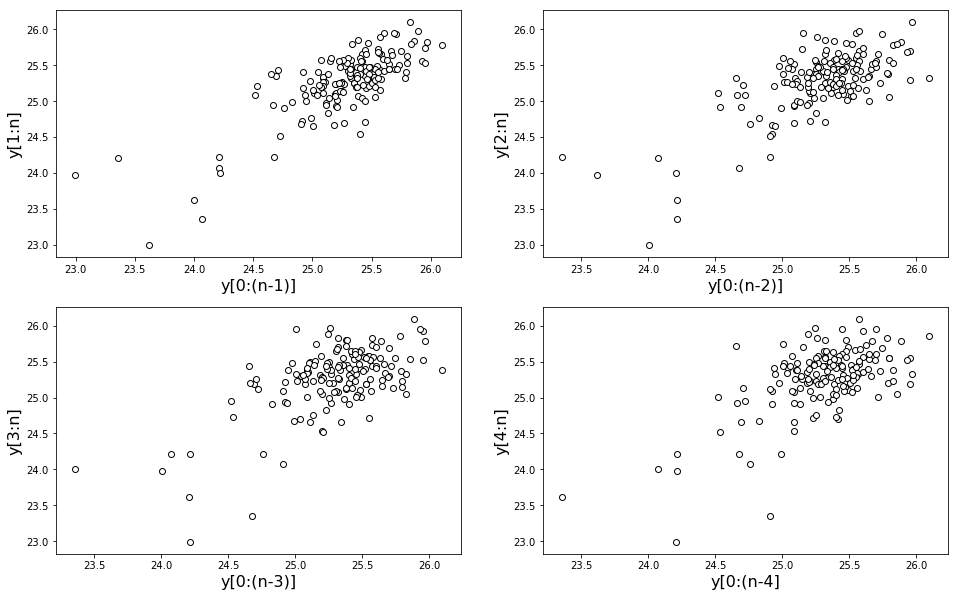

In [21]:
fig, ax = plt.subplots(2,2,figsize=(16,10))            # Set up figure and subplots
ax[0,0].scatter(y[:-1],y[1:],edgecolor='k',facecolor='w')      # scatter plot of values shifted by 1
ax[0,0].set_xlabel('y[0:(n-1)]',fontsize=16)            # x axis label
ax[0,0].set_ylabel('y[1:n]',fontsize=16)                # y axis label
ax[0,1].scatter(y[:-2],y[2:],edgecolor='k',facecolor='w')      # scatter plot of values shifted by 2
ax[0,1].set_xlabel('y[0:(n-2)]',fontsize=16)            # x axis label
ax[0,1].set_ylabel('y[2:n]',fontsize=16)                # y axis label
ax[1,0].scatter(y[:-3],y[3:],edgecolor='k',facecolor='w')      # scatter plot of values shifted by 3
ax[1,0].set_xlabel('y[0:(n-3)]',fontsize=16)            # x axis label
ax[1,0].set_ylabel('y[3:n]',fontsize=16)                # y axis label
ax[1,1].scatter(y[:-4],y[4:],edgecolor='k',facecolor='w')      # scatter plot of values shifted by 4
ax[1,1].set_xlabel('y[0:(n-4]',fontsize=16)            # x axis label
ax[1,1].set_ylabel('y[4:n]',fontsize=16)                # y axis label
plt.show()

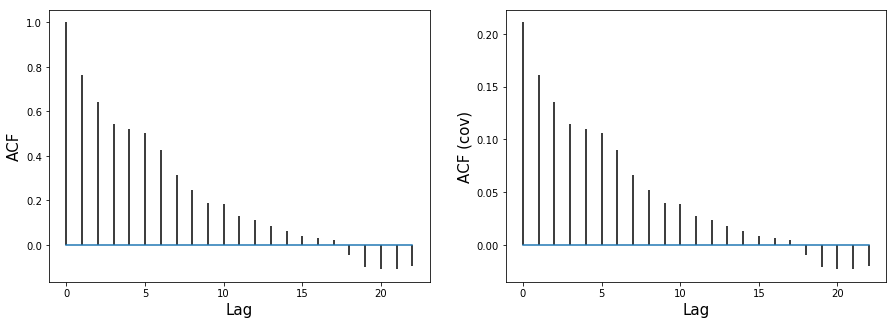

In [22]:
fig, ax = plt.subplots(1,2,figsize=(15,5))            # Set up figure and subplots
acf_corr = np.squeeze(np.array(stats.acf(robjs.FloatVector(y), ci=0, main='', type='correlation')[0]))
acf_cov = np.squeeze(np.array(stats.acf(robjs.FloatVector(y), ci=0, main='', type='covariance')[0]))
n = len(acf_corr) #number of lags
#-0 Plot Autocorrelation
ax[0].vlines(range(n),[0],acf_corr)       # plot vertical lines
ax[0].plot(range(n),np.zeros(n))          # plot zero line
ax[0].set_ylabel('ACF',fontsize=15)       # label y axis  
ax[0].set_xlabel('Lag', fontsize=15)      # label x axis
#-- Plot Autocovariance
ax[1].vlines(range(n),[0],acf_cov)        # plot vertical lines
ax[1].plot(range(n),np.zeros(n))          # plot zero line
ax[1].set_ylabel('ACF (cov)',fontsize=15) # label y axis
ax[1].set_xlabel('Lag',fontsize=15)       # label x axis
plt.show()

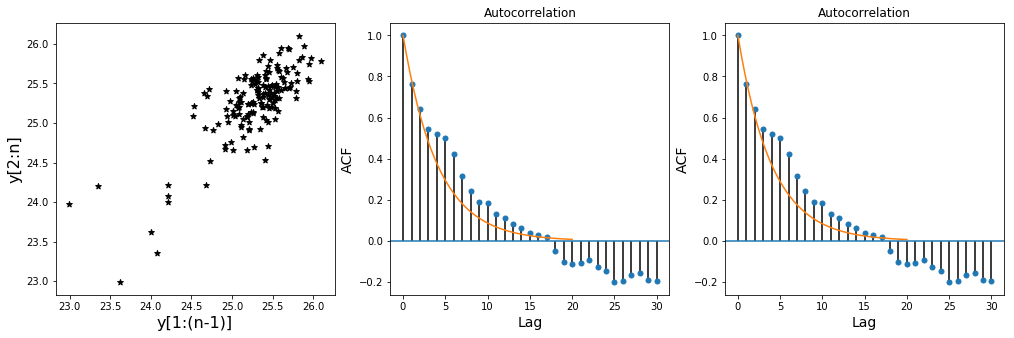

In [23]:
fig, ax = plt.subplots(1,3,figsize=(17,5))            # Set up figure and subplots
ax[0].scatter(y[:-1],y[1:],color='k',marker='*')      # scatter plot of values shifted by 1
ax[0].set_xlabel('y[1:(n-1)]',fontsize=16)            # x axis label
ax[0].set_ylabel('y[2:n]',fontsize=16)                # y axis label
sm.graphics.tsa.plot_acf(y,lags=30,alpha=np.float('nan'),ax=ax[1]) # plot empirical autocorrelation function
alpha_hat = np.corrcoef(y[:-1],y[1:])[0,1]           # the correlation coefficient between lagged values
ax[1].plot(np.linspace(0,20),alpha_hat**np.linspace(0,20))        # line for theoretical acf using correlation coeff
ax[1].set_xlabel('Lag', fontsize=14)                  # x axis label
ax[1].set_ylabel('ACF',fontsize=14)                   # y axis label
sm.graphics.tsa.plot_acf(y,lags=30,alpha=np.float('nan'),ax=ax[2]) # plot empirical autocorrelation function
ax[2].plot(np.linspace(0,20),0.78**np.linspace(0,20)) # plot optimized autocorrelation function (more info below)
ax[2].set_xlabel('Lag', fontsize=14)                  # x axis label
ax[2].set_ylabel('ACF',fontsize=14)                   # y axis label
plt.show()

In [24]:
# Fit a linear regression between y and time, specifying a first order autoregressive covariance matrix. 
# Specify method='ML' to fit exact maximum likelihood
print(r.summary(nlme.gls(r.formula("y ~ t1"), correlation=nlme.corAR1(),method='ML')))

Generalized least squares fit by maximum likelihood
  Model: y ~ t1 
  Data: NULL 
       AIC      BIC    logLik
  59.81062 72.21009 -25.90531

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.7662343 

Coefficients:
               Value Std.Error   t-value p-value
(Intercept) 32.43808  3.655355  8.874128  0.0000
t1          -0.00373  0.001892 -1.971625  0.0504

 Correlation: 
   (Intr)
t1 -1    

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-4.40980463 -0.35191840  0.05324723  0.53181699  2.38815117 

Residual standard error: 0.4398229 
Degrees of freedom: 164 total; 162 residual



### Harmonic regression

In [50]:
nyrs = t1.max() - t1.min() + 1
f = np.linspace(0, 2*np.pi*nyrs, len(y), dtype=np.float64)
sinf = np.sin(f)
cosf = np.cos(f)

In [53]:
robjs.globalenv["sinf"] = robjs.FloatVector(sinf) # Add sine to R envrionment as FloatVector
robjs.globalenv["cosf"] = robjs.FloatVector(cosf) # Add cose to R envrionment as FloatVector
#-- fit regression with seasonal component and first order autoregressive covariance matrix
print(r.summary(nlme.gls(r.formula("y ~ sinf + cosf"), correlation=nlme.corAR1(),method='ML')))

Generalized least squares fit by maximum likelihood
  Model: y ~ sinf + cosf 
  Data: NULL 
       AIC      BIC    logLik
  64.35065 79.84999 -27.17533

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.7916349 

Coefficients:
                Value Std.Error   t-value p-value
(Intercept) 25.236001 0.1055274 239.14161  0.0000
sinf         0.028011 0.1507382   0.18582  0.8528
cosf        -0.136508 0.1438820  -0.94875  0.3442

 Correlation: 
     (Intr) sinf  
sinf  0.000       
cosf -0.068  0.000

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-4.5169326 -0.3833876  0.2399163  0.6819041  2.0077035 

Residual standard error: 0.465999 
Degrees of freedom: 164 total; 161 residual



## Time series decomposition

In [60]:
fit = nlme.gls(r.formula('y ~ sinf + cosf + t1'), correlation=nlme.corAR1(), method='ML')

In [61]:
k_hat = fit.rx2('coefficients')          # extract fitted regression coefficients
print(k_hat)                              # Display for comparison with R
k_hat_var = np.array(fit.rx2('varBeta')) # extract the associated errors
print(k_hat_var)                          # Display for comparison with R
phi_hat = stats.coef(fit.rx2("modelStruct"),unconstrained=False) #extract fitted autoregressive parameter
e = np.array(fit.rx2('residuals'))       #extract 'raw' residuals (yi - ypred) 

 (Intercept)         sinf         cosf           t1 
39.035113404 -0.332826440 -0.122603644 -0.007140399 

[[  2.07330197e+01  -5.48975303e-01  -4.33205791e-04  -1.07309580e-02]
 [ -5.48975303e-01   2.71506225e-02   7.77701552e-16   2.84222264e-04]
 [ -4.33205791e-04   7.77701552e-16   1.17559677e-02   1.43198920e-17]
 [ -1.07309580e-02   2.84222264e-04   1.43198920e-17   5.55576392e-06]]


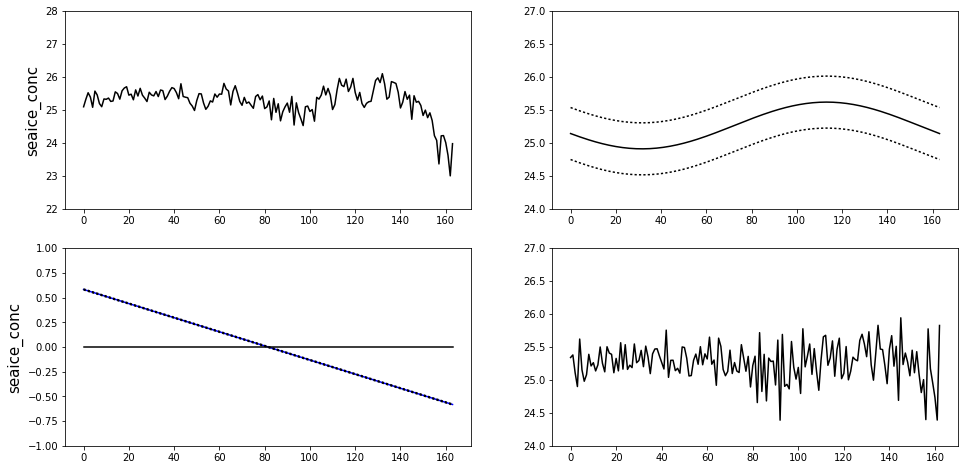

In [82]:
#-- Plot results
fig, ax = plt.subplots(2,2,figsize=(16,8))    # set up figure and panels
ax[0,0].plot(y,'k-')                         # plot the data
ax[0,0].set_ylim([22,28])                    # y axis range
ax[0,0].set_ylabel('seaice_conc',fontsize=15) # y axis label

f_hat = np.mean(y) + k_hat[1]*sinf + k_hat[2]*cosf  # fitted seasonal cycle
ax[0,1].plot(f_hat,'k-')                             # plot fitted seasonal cycle
#-- add 95% CIs (upper and lower); note the variance is already std^2
ax[0,1].plot(f_hat + 2*np.sqrt(k_hat_var[1,1] + k_hat_var[2,2]),'k:') 
ax[0,1].plot(f_hat - 2*np.sqrt(k_hat_var[1,1] + k_hat_var[2,2]),'k:')
ax[0,1].set_ylim([24,27])                           # y axis range

t_hat = k_hat[0] + k_hat[3]*t1                       # fitted trend
t_hat -= np.mean(t_hat)                              # normalize to the zero-line
ax[1,0].plot(t_hat,'b-')                             # plot fitted trend
ax[1,0].plot(t_hat + 2*np.sqrt(k_hat_var[3,3]),'k:') # upper 95% CI
ax[1,0].plot(t_hat - 2*np.sqrt(k_hat_var[3,3]),'k:') # lower  95% CI
ax[1,0].plot(np.zeros(len(t_hat)),'k-')              # add 0 line 
ax[1,0].set_ylabel('seaice_conc',fontsize=15)        # y axis label
ax[1,0].set_ylim([-1,1])                     # y axis range

ear = e[1:]-phi_hat*e[:-1]                    # subtract the autoregression
ax[1,1].plot(np.mean(y)+ear,'k-')            # plot the residuals
ax[1,1].set_ylim([24,27])                  # y axis range
plt.show()

In [81]:
k_hat_var[1,1]

0.027150622474418608

In [ ]:
seasons = nc.seaice_conc.groupby('time.season').mean('latitude').mean('longitude')

In [ ]:
seas_df = seasons.to_dataframe()

In [ ]:
seas_df.head()

In [ ]:
seas_df = seas_df.groupby([lambda x: x.year, 'season']).mean()
seas_df = seas_df.reset_index()

In [ ]:
seas_df.head(n=12)

In [ ]:
seas_df.rename(columns={'level_0': 'year'}, inplace=True)
seas_df.head(n=12)

In [ ]:
djf_df = seas_df.loc[seas_df['season'] == 'DJF']
jja_df = seas_df.loc[seas_df['season'] == 'JJA']
mam_df = seas_df.loc[seas_df['season'] == 'MAM']
son_df = seas_df.loc[seas_df['season'] == 'SON']

In [ ]:
djf_df.head()

In [ ]:
djf = go.Scatter(
    x = djf_df.year,
    y = djf_df['seaice_conc'],
    name = 'DJF Seaice Conc',
    opacity = 0.8)

jja = go.Scatter(
    x = jja_df.year,
    y = jja_df['seaice_conc'],
    name = 'JJA Seaice Conc',
    opacity = 0.8)

mam = go.Scatter(
    x = mam_df.year,
    y = mam_df['seaice_conc'],
    name = 'MAM Seaice Conc',
    opacity = 0.8)

son = go.Scatter(
    x = son_df.year,
    y = son_df['seaice_conc'],
    name = 'SON Seaice Conc',
    opacity = 0.8)

data = [djf, jja, mam, son]

layout = dict(
    title='Yearly Seasonal Seaice Averages',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=5,
                     label='5yr',
                     step='year',
                     stepmode='backward'),
                dict(count=10,
                     label='10yr',
                     step='year',
                     stepmode='backward'),
                dict(count=25,
                     label='25yr',
                     step='year',
                     stepmode='backward'),
                dict(count=50,
                     label='50yr',
                     step='year',
                     stepmode='backward'),
                dict(count=100,
                     label='100yr',
                     step='year',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(),
        type='date'
    )
)

In [ ]:
fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "Seasonal Seaice Averages")

In [ ]:
y2 = nc.
t2 = djf_df.year

In [ ]:
robjs.globalenv['y2'] = robjs.FloatVector(y)
robjs.globalenv['t2'] = robjs.FloatVector(t1)
print(r.summary(nlme.gls(r.formula("y2 ~ t2"), correlation=nlme.corAR1(),method='ML')))

In [ ]:
lat = nc.latitude.values
lon = nc.longitude.values
conc = nc.seaice_conc.values

In [ ]:
def plot_contour_arctic(conc, lon, lat, idx, title=None, save_path=None):
    fig = plt.figure(figsize=(10, 10))
    
    levels = np.arange(0, 100, 10)

    lat_min = 30.0
    lat_max = 80.0
    lon_min = -180
    lon_max = 180

    m = Basemap(width=10.e6, height=11e6,
                projection='gnom', lat_0=88.0, lon_0=-30.0)

    x, y = m(*np.meshgrid(lon[:], lat[:]))
    m.drawcoastlines(color='black')
    m.fillcontinents(color='gray')

    m.drawmeridians(np.arange(np.min(lon), np.max(lon), 20),labels=[0,0,0,1])
    m.drawparallels(np.arange(lat_min, lat_max,10),labels=[1,0,0,0])

    CS1 = m.contourf(x,y,conc[idx,:,:],
                     levels,cmap=plt.get_cmap('RdYlBu_r',len(levels)-1),
                     extend='max')
    CS1.axis='tight'
    plt.colorbar(CS1,orientation='vertical',extend='max', shrink=0.5)

In [ ]:
plot_contour_arctic(conc, lon, lat, 1000)
#del lat, lon, conc

In [ ]:
#years_ds = [group for label, group in list(ds.groupby('time.year'))]
#seasons_ds = [y.groupby('time.season').mean('time') for y in years_ds]
#frames = [s.seaice_conc.to_dataframe().reset_index() for s in seasons_ds]
#for y, f in enumerate(frames):
#    f.insert(0, 'year', 1850+y)

#Xdf = pd.concat(frames)
#Xdf.head()

In [ ]:
#Xdf.rename(columns={'latitude': 'lat', 'longitude': 'lon', 'seaice_conc': 'conc'}, inplace=True)

In [ ]:
# Save Xdf as csv
#Xdf.to_csv('data/yearly_seasonal_conc.csv', index=False)


In [ ]:
## Partition dataset by season
#df = pd.read_csv('data/yearly_seasonal_conc.csv')
#
#djf = df.loc[df['season'] == 'DJF']
#mam = df.loc[df['season'] == 'MAM']
#jja = df.loc[df['season'] == 'JJA']
#son = df.loc[df['season'] == 'SON']
#
## Free up
#import gc
#del df
#gc.collect()
#gc.collect()
#%reset out
#
## Write 
#djf.to_csv('data/djf_conc.csv', index=False)
#mam.to_csv('data/mam_conc.csv', index=False)
#jja.to_csv('data/jja_conc.csv', index=False)
#son.to_csv('data/son_conc.csv', index=False)